# Hands on : introduction to NN on HEP dataset

### Many thanks to _Fernando Torales Acosta, David Rousseau, Yann Coadou_, and _Aishik Gosh_

## Import Packages

[This should look familiar!]

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot as ur

import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from IPython.display import display, HTML
%matplotlib inline
import time
pd.set_option('display.max_columns', None) # to see all columns of df.head()
np.random.seed(31415) # set the random seed for the reproducibility

In [2]:
print(tf.__version__)

2.9.1


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


# Load events

data was created from ATLAS Open Data

In [4]:
filename=("dataWW_d1.root")
file = ur.open(filename)
print(file.classnames())
#print(file.keys())


{'tree_event;1': 'TTree'}


In [5]:
tree = file["tree_event"]
print(tree.keys())

['index', 'eventNumber', 'label', 'met_et', 'met_phi', 'lep_n', 'lep_pt_0', 'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0', 'lep_phi_1', 'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1', 'lep_type_0', 'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1', 'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1', 'jet_E_0', 'jet_E_1', 'mcWeight', 'runNumber', 'channelNumber']


In [6]:
print(type(tree))
tree.show()
dfall = tree.arrays(library="pd")

<class 'uproot.models.TTree.Model_TTree_v20'>
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
index                | int64_t                  | AsDtype('>i8')
eventNumber          | int64_t                  | AsDtype('>i8')
label                | int64_t                  | AsDtype('>i8')
met_et               | double                   | AsDtype('>f8')
met_phi              | double                   | AsDtype('>f8')
lep_n                | int64_t                  | AsDtype('>i8')
lep_pt_0             | double                   | AsDtype('>f8')
lep_pt_1             | double                   | AsDtype('>f8')
lep_eta_0            | double                   | AsDtype('>f8')
lep_eta_1            | double                   | AsDtype('>f8')
lep_phi_0            | double                   | AsDtype('>f8')
lep_phi_1            | double                   | AsDtype('>f8')
lep_E_0     

[uproot](https://indico.cern.ch/event/686641/contributions/2894906/attachments/1606247/2548596/pivarski-uproot.pdf)

In [7]:
#shuffle the events [already done but just to be safe]
dfall = dfall.sample(frac=1).reset_index(drop=True)
print ("File loaded with ",dfall.shape[0], " events ")

File loaded with  600000  events 


#### At this point, you should see "File Loaded with [XXX] events". If not, the data file could not be accessed. No point going further!

# Examine Pandas Dataset

In [8]:
#examine first few events
dfall.head()

,index,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
0,543448,402756,1,25.609,0.42452,2,48.295,15.214,0.73991,2.27420,-2.316400,-1.39410,62129.0,74721.0,-1,1,13,11,2,26.32,20.064,-1.1350,-2.07540,-2.8092,2.0740,45397.0,81304.0,0.000002,284500,345323
1,580260,101274,0,196.560,1.31140,2,69.459,21.081,-0.52666,0.22380,0.023132,-0.67855,79317.0,21611.0,-1,1,13,13,2,192.12,36.217,-1.2643,-0.69746,-2.2147,-1.9152,367670.0,45733.0,0.000288,284500,363492
2,112856,468437,1,45.653,-2.76860,2,45.927,22.822,-1.61910,-2.00770,1.901700,-0.11248,120480.0,86498.0,-1,1,11,11,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000029,284500,345324
3,121430,272337,1,49.415,-0.57805,2,45.929,14.263,1.55280,0.12809,2.254700,-2.54810,113360.0,14380.0,-1,1,13,13,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000029,284500,345324
4,55912,354546,1,71.988,-2.60390,2,62.029,21.453,-0.51082,-0.38177,0.236200,1.40820,70300.0,23036.0,-1,1,11,13,0,-7.00,-7.000,-7.0000,-7.00000,-7.0000,-7.0000,-7.0,-7.0,0.000002,284500,345323


In [9]:
#take a look at feature distribution
dfall.describe()
#dfall.head(5)

,index,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,lep_phi_0,lep_phi_1,lep_E_0,lep_E_1,lep_charge_0,lep_charge_1,lep_type_0,lep_type_1,jet_n,jet_pt_0,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
count,600000.000000,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05,6.000000e+05,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,600000.000000,6.000000e+05,6.000000e+05,600000.000000,600000.0,600000.000000
mean,299999.500000,7.029775e+05,0.666667,60.365356,-0.008556,2.005748,60.270328,28.133970,0.000269,-0.000664,0.005219,0.008524,1.164008e+05,5.630948e+04,-0.027027,0.027037,11.907273,11.958010,1.334185,59.606114,13.521164,-1.934521,-4.402337,-1.939645,-4.401941,1.375410e+05,4.125468e+04,0.000218,284500.0,351379.666667
std,173205.225094,4.568961e+05,0.471405,48.153210,1.812778,0.076061,42.676858,20.352272,1.210614,1.235890,1.811177,1.814205,1.083341e+05,5.748834e+04,0.999636,0.999635,0.995692,0.999119,1.232632,79.586143,38.074439,3.349404,3.491304,3.489197,3.559421,1.980717e+05,8.990068e+04,0.000736,0.0,8564.720183
min,0.000000,1.000000e+00,0.000000,0.044211,-3.141600,2.000000,25.000000,7.000300,-2.700000,-2.699900,-3.141600,-3.141600,2.501300e+04,7.003800e+03,-1.000000,-1.000000,11.000000,11.000000,0.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000e+00,-7.000000e+00,-0.045557,284500.0,345323.000000
25%,149999.750000,3.498568e+05,0.000000,33.196000,-1.577600,2.000000,36.624750,15.316000,-0.899650,-0.946043,-1.560200,-1.562900,5.221675e+04,2.329100e+04,-1.000000,-1.000000,11.000000,11.000000,0.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000e+00,-7.000000e+00,0.000002,284500.0,345323.000000
50%,299999.500000,6.678815e+05,1.000000,50.082000,-0.018694,2.000000,48.229500,23.644000,0.003413,0.002974,0.014583,0.018823,8.184450e+04,3.824900e+04,-1.000000,1.000000,11.000000,11.000000,1.000000,38.744000,-7.000000,-0.891010,-7.000000,-1.210600,-7.000000,7.501700e+04,-7.000000e+00,0.000029,284500.0,345324.000000
75%,449999.250000,1.001273e+06,1.000000,73.032250,1.559300,2.000000,68.979000,34.149000,0.901950,0.942210,1.573000,1.577300,1.412400e+05,6.730825e+04,1.000000,1.000000,13.000000,13.000000,2.000000,84.291250,26.881000,0.724705,-0.821005,0.967753,-1.088575,1.766200e+05,5.060500e+04,0.000197,284500.0,363492.000000
max,599999.000000,1.997995e+06,1.000000,7062.200000,3.141600,5.000000,7041.400000,744.900000,2.699800,2.700000,3.141500,3.141600,7.041600e+06,2.107900e+06,1.000000,1.000000,13.000000,13.000000,13.000000,1658.200000,1429.800000,2.500000,2.500000,3.141600,3.141600,5.638800e+06,2.784300e+06,0.052420,284500.0,363492.000000


In [10]:
label_weights = (dfall[dfall.label==0].mcWeight.sum(), dfall[dfall.label==1].mcWeight.sum() ) 
print("total label weights",label_weights)

label_nevents = (dfall[dfall.label==0].shape[0], dfall[dfall.label==1].shape[0] )
print ("total class number of events",label_nevents)

total label weights (124.6622944642, 6.2000533976)
total class number of events (200000, 400000)


## Event Selection

This notebook essentially tries to classify events containing a Higgs Boson.

The simulation includes top-quark-pair production, single-top production, production of weak bosons in association with jets (W+jets, Z+jets), production of a pair of bosons (diboson WW, WZ, ZZ) and __SM Higgs__ production.

We will only keep events with exactly two leptons dfall.lep_n==2

In [11]:
print (dfall.shape)

# Also only keep events with positive weight. This is in principle wrong. 
#Many Data Science tools break given a negative weight.

fulldata=dfall[(dfall.lep_n==2) & (dfall.mcWeight>0 )] # only keep events with exactly two leptons 
print (fulldata.shape)

(600000, 30)
(577357, 30)


In [12]:
#hide label and weights in separate vectors
#they are not real features

#WARNING : there should be no selection nor shuffling later on !
target = fulldata["label"]
del fulldata["label"]

#hide weight in separate vector
weights = fulldata["mcWeight"]
del fulldata["mcWeight"]
fulldata.shape

(577357, 28)

___


# Try not to change the cells above $\uparrow$
...and return to this cell (or rerun the whole notebook) after changing things below.

___

### For simplicity, we'll only use some features on the first pass

In [13]:
data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_phi_0', 'lep_phi_1'])
print (data.shape)
data.head()

(577357, 6)


,met_et,met_phi,lep_pt_0,lep_pt_1,lep_phi_0,lep_phi_1
0,25.609,0.42452,48.295,15.214,-2.316400,-1.39410
1,196.560,1.31140,69.459,21.081,0.023132,-0.67855
2,45.653,-2.76860,45.927,22.822,1.901700,-0.11248
3,49.415,-0.57805,45.929,14.263,2.254700,-2.54810
4,71.988,-2.60390,62.029,21.453,0.236200,1.40820


### Feature engineering (Two variations)

1. See if using more features improves model performance

In [14]:
more_features = False
if (more_features):
    data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_eta_0', 'lep_eta_1', 'lep_phi_0', 'lep_phi_1','jet_n','jet_pt_0',
       'jet_pt_1', 'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1'])

2. Engineer our own feature, $\Delta\varphi_l$

In [15]:
use_deltaphi = False
if use_deltaphi: 
    data["lep_deltaphi"]=np.abs(np.mod(data.lep_phi_1-data.lep_phi_0+3*np.pi,2*np.pi)-np.pi)

    print (data.shape)
    display(data.head())

<Figure size 640x480 with 0 Axes>

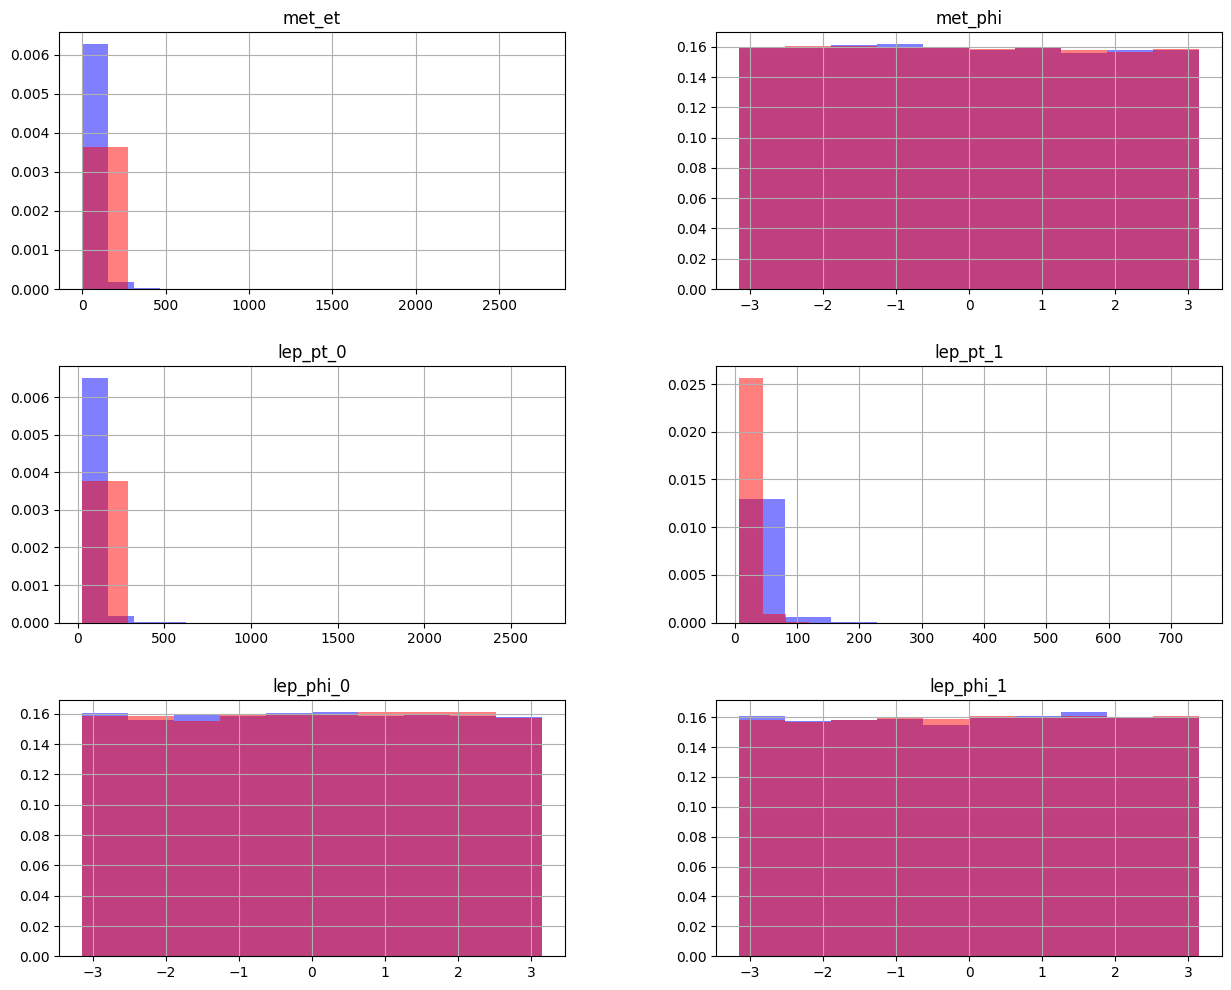

In [16]:
plt.figure()

ax=data[target==0].hist(weights=weights[target==0],figsize=(15,12),color='b',alpha=0.5,density=True)
ax=ax.flatten()[:data.shape[1]] # to avoid error if holes in the grid of plots (like if 7 or 8 features)
data[target==1].hist(weights=weights[target==1],figsize=(15,12),color='r',alpha=0.5,density=True,ax=ax)

plt.show()

# Transform the features

### Split the Data into Training and Test

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
train_size = 0.1 # fraction of sample used for training
# Try changing fraction to increase or decrease sample

X_train, X_test, y_train, y_test, weights_train, weights_test = \
    train_test_split(data, target, weights, train_size=train_size)

y_train, y_test, weights_train, weights_test = \
    y_train.reset_index(drop=True),y_test.reset_index(drop=True), \
    weights_train.reset_index(drop=True), weights_test.reset_index(drop=True)

print ("Xtrain Shape: ",X_train.shape)
print ("ytrain Shape: ",y_train.shape)
print ("Training Weights: ",weights_train.shape,"\n")
print ("Xtest Shape: ",X_test.shape)
print ("ytest Shape: ",y_test.shape)
print ("Test Weights: ",weights_test.shape)

Xtrain Shape:  (57735, 6)
ytrain Shape:  (57735,)
Training Weights:  (57735,) 

Xtest Shape:  (519622, 6)
ytest Shape:  (519622,)
Test Weights:  (519622,)


### Doing an extra data split. Test _and_ Validation

In [24]:
X_test, X_val, y_test, y_val, weights_test, weights_val, = \
    train_test_split(X_test, y_test, weights_test, train_size=0.5, shuffle=False)

- __Training Dataset:__ The sample of data used to fit the model.
- __Validation Dataset:__ The sample used to provide an unbiased evaluation of a model fit on the training dataset while tuning  hyperparameters.
- __Test Dataset:__ The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.

## Standardize the Data

**Scale to Mean of 0 and Variance of 1.0:**   $\ \ \ \ (x-\mu)/\sigma$

In [25]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test) #applies the transformation calculated the line above

### Adjust the Test and Train Signal/Background Weights
Train on equal amount of Signal and Background, Test on 'natural' ratio

In [26]:
class_weights_train = (weights_train[y_train == 0].sum(), weights_train[y_train == 1].sum())
print ("class_weights_train:",class_weights_train)
for i in range(len(class_weights_train)):
    weights_train[y_train == i] *= max(class_weights_train)/ class_weights_train[i] #equalize number of background and signal event
    weights_test[y_test == i] *= 1/(1-train_size) #increase test weight to compensate for sampling
    
print ("Train : total weight sig", weights_train[y_train == 1].sum())
print ("Train : total weight bkg", weights_train[y_train == 0].sum())
print ("Test : total weight sig", weights_test[y_test == 1].sum())
print ("Test : total weight bkg", weights_test[y_test == 0].sum())

class_weights_train: (15.817937764599996, 0.6176987656)
Train : total weight sig 15.817937764599996
Train : total weight bkg 15.817937764599996
Test : total weight sig 3.092884297333334
Test : total weight bkg 80.0742451968889


# Trying NN

## NN

In [27]:
#Quickly take a look at weights
print(X_train.shape)
print(class_weights_train)
print(weights_train)

(57735, 6)
(15.817937764599996, 0.6176987656)
0        0.000051
1        0.000051
2        0.000206
3        0.000746
4        0.001966
           ...   
57730    0.000051
57731    0.000051
57732    0.000051
57733    0.000336
57734    0.000746
Name: mcWeight, Length: 57735, dtype: float64


In [28]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_train.shape[1],)), # input layer
    tf.keras.layers.Dense(128, activation='relu'), # 1st hiddden layer
    tf.keras.layers.Dense(128, activation='relu'), # 2nd hiddden layer
    tf.keras.layers.Dense(1,activation="sigmoid") # output layer
])
model.compile(loss="binary_crossentropy", optimizer="adam")

In [31]:
starting_time = time.time( )
the_fit = model.fit(X_train, y_train.values, epochs=10,
                     sample_weight=weights_train)
#not using validation dataset here; keras does not support val weights
#Solution: Define your own loss function that takes train and val loss! 

training_time = time.time( ) - starting_time
print("Training time:",training_time)

Epoch 1/10
1805/1805 [==============================] - 2s 1ms/step - loss: 2.2866e-04
Epoch 2/10
1805/1805 [==============================] - 2s 1ms/step - loss: 2.2796e-04
Epoch 3/10
1805/1805 [==============================] - 2s 1ms/step - loss: 2.2799e-04
Epoch 4/10
1805/1805 [==============================] - 2s 1ms/step - loss: 2.2714e-04
Epoch 5/10
1805/1805 [==============================] - 2s 1ms/step - loss: 2.2617e-04
Epoch 6/10
1805/1805 [==============================] - 2s 1ms/step - loss: 2.2582e-04
Epoch 7/10
1805/1805 [==============================] - 2s 1ms/step - loss: 2.2569e-04
Epoch 8/10
1805/1805 [==============================] - 2s 1ms/step - loss: 2.2560e-04
Epoch 9/10
1805/1805 [==============================] - 2s 1ms/step - loss: 2.2456e-04
Epoch 10/10
1805/1805 [==============================] - 2s 1ms/step - loss: 2.2439e-04
Training time: 33.54951333999634


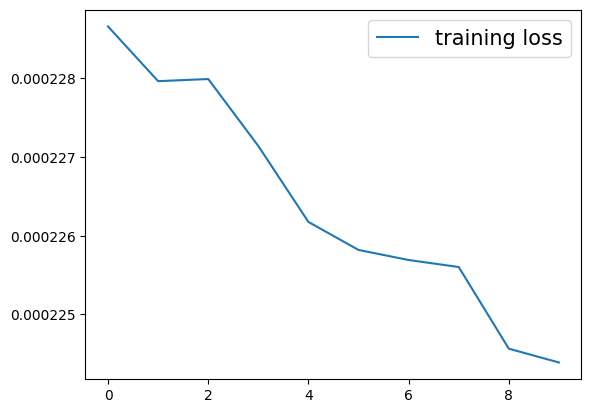

In [32]:
plt.plot(the_fit.history['loss'],label="training loss")
plt.legend(fontsize=15)

### Use the model to make predicions!
Evaluate the model based on predictions made with X_test $\rightarrow$ y_test

In [37]:
y_pred_test = model.predict(X_test).ravel()
y_pred_train = model.predict(X_train).ravel()

1805/1805 [==============================] - 2s 825us/step


In [38]:
### ROC curves and Area Under the Curve (AUC)

In [39]:
from sklearn.metrics import roc_auc_score # for binary classification if x > 0.5 -> 1 else -> 0
from sklearn.utils import class_weight # to set class_weight="balanced"

Text(0.5, 1.0, 'Receiver Operating Characteristic')

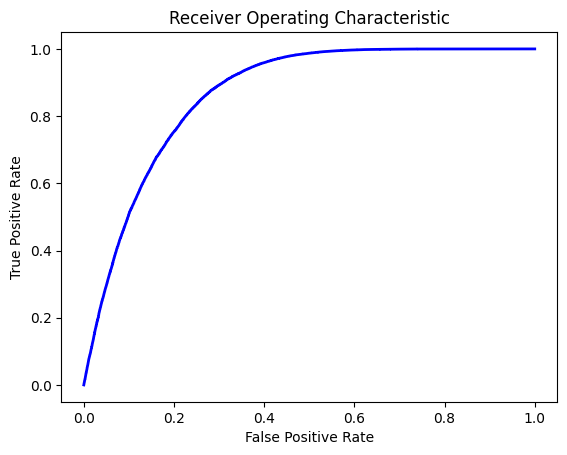

In [40]:
from sklearn.metrics import roc_curve
fpr,tpr,_ = roc_curve(y_true=y_test, y_score=y_pred_test,sample_weight=weights_test)
plt.plot(fpr, tpr, color='blue',lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')

In [41]:
auc_test = roc_auc_score(y_true=y_test, y_score=y_pred_test,sample_weight=weights_test)
auc_train = roc_auc_score(y_true=y_train.values, y_score=y_pred_train,sample_weight=weights_train)
print("auc test:",auc_test)
print ("auc train:",auc_train)

auc test: 0.8654179984084927
auc train: 0.8854792158752542


## Significance Function

$\mathrm{med}[Z_0|1] = \sqrt{q_{0,A}} = \sqrt{2+((s+b)\ln(1+s/b)-s)}$

**asimov significance [arXiv:1007.1727](https://arxiv.org/pdf/1007.1727.pdf) [Eq. 97]**

Likelihood-based statistical test for significance. Need to esimate your sensitivity to MC. Running a toy MC thousands of times, should converge to 'truth'. Asimov is representative of number of sigmas in the gaus case.

Essentially: For an observed number of signal events $s$, what is the significance $Z_0$ with which we would reject the $s = 0$ hypothesis

In [42]:
from math import sqrt
from math import log
def amsasimov(s,b):
        if b<=0 or s<=0:
            return 0
        try:
            return sqrt(2*((s+b)*log(1+float(s)/b)-s))
        except ValueError:
            print(1+float(s)/b)
            print (2*((s+b)*log(1+float(s)/b)-s))
        #return s/sqrt(s+b)

In [43]:
#from extra_functions import amsasimov

In [44]:
int_pred_test_sig = [weights_test[(y_test ==1) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
int_pred_test_bkg = [weights_test[(y_test ==0) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0,1,num=50)]
vamsasimov = [amsasimov(sumsig,sumbkg) for (sumsig,sumbkg) in zip(int_pred_test_sig,int_pred_test_bkg)]
Z = max(vamsasimov)
print("Z:",Z)

Z: 0.5696417563778592


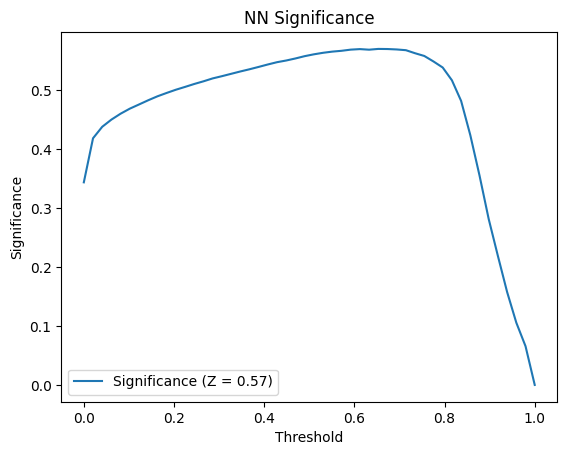

In [45]:
plt.plot(np.linspace(0,1,num=50),vamsasimov, label='Significance (Z = {})'.format(np.round(Z,decimals=2)))


plt.title("NN Significance")
plt.xlabel("Threshold")
plt.ylabel("Significance")
plt.legend()
plt.savefig("Significance_xgb.pdf")
plt.show()

### Plotting NN Score for Signal and Background

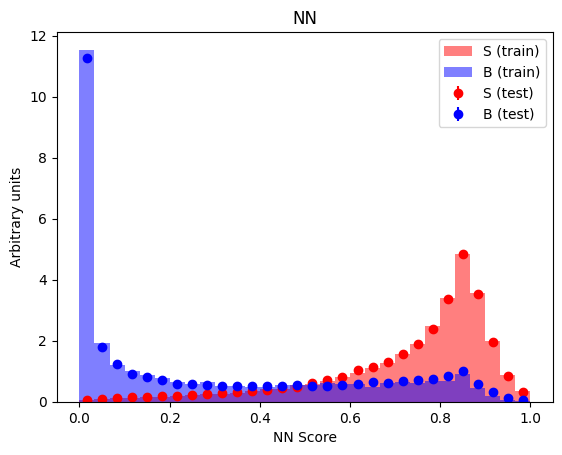

In [47]:
from extra_functions import compare_train_test
compare_train_test(y_pred_train, y_train, y_pred_test, y_test, 
                   xlabel="NN Score", title="NN", 
                   weights_train=weights_train.values, weights_test=weights_test.values)

## What does overtraining look like?

Recipe:
1. Add More layers
2. Add more nodes per layer
3. Train on less data

In [48]:
#Crazy Example
N = len(X_train)
n = int(N/1000)
print("Using",n,"/",N, "events")

X_small = X_train[:n]
y_small = y_train[:n]
weights_small = weights_train[:n]

Using 57 / 57735 events


In [49]:
ot_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(X_small.shape[1],)), # input layer
    tf.keras.layers.Dense(256, activation='relu'), # 1st hiddden layer
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1,activation="sigmoid")
])
ot_model.compile(loss="binary_crossentropy", optimizer="adam")
starting_time = time.time( )

the_overfit = ot_model.fit(X_small, y_small.values, epochs=25 ,validation_data=(X_val, y_val))
#Here, we are not using any sample weights. 
#This is just an example so we omits weights to show val loss

training_time = time.time( ) - starting_time
print("Training time:",training_time)

Epoch 1/25
2/2 [==============================] - 8s 7s/step - loss: 0.6453 - val_loss: 0.6113
Epoch 2/25
2/2 [==============================] - 7s 7s/step - loss: 0.5460 - val_loss: 0.5757
Epoch 3/25
2/2 [==============================] - 7s 7s/step - loss: 0.4743 - val_loss: 0.5600
Epoch 4/25
2/2 [==============================] - 7s 7s/step - loss: 0.4151 - val_loss: 0.5599
Epoch 5/25
2/2 [==============================] - 8s 8s/step - loss: 0.3650 - val_loss: 0.5703
Epoch 6/25
2/2 [==============================] - 8s 8s/step - loss: 0.3241 - val_loss: 0.5859
Epoch 7/25
2/2 [==============================] - 8s 8s/step - loss: 0.2918 - val_loss: 0.6119
Epoch 8/25
2/2 [==============================] - 8s 8s/step - loss: 0.2607 - val_loss: 0.6548
Epoch 9/25
2/2 [==============================] - 8s 8s/step - loss: 0.2411 - val_loss: 0.7095
Epoch 10/25
2/2 [==============================] - 8s 8s/step - loss: 0.2160 - val_loss: 0.7651
Epoch 11/25
2/2 [==============================] 

In [50]:
ot_y_pred_test = ot_model.predict(X_test).ravel()
ot_y_pred_train = ot_model.predict(X_small).ravel()

2/2 [==============================] - 0s 2ms/step


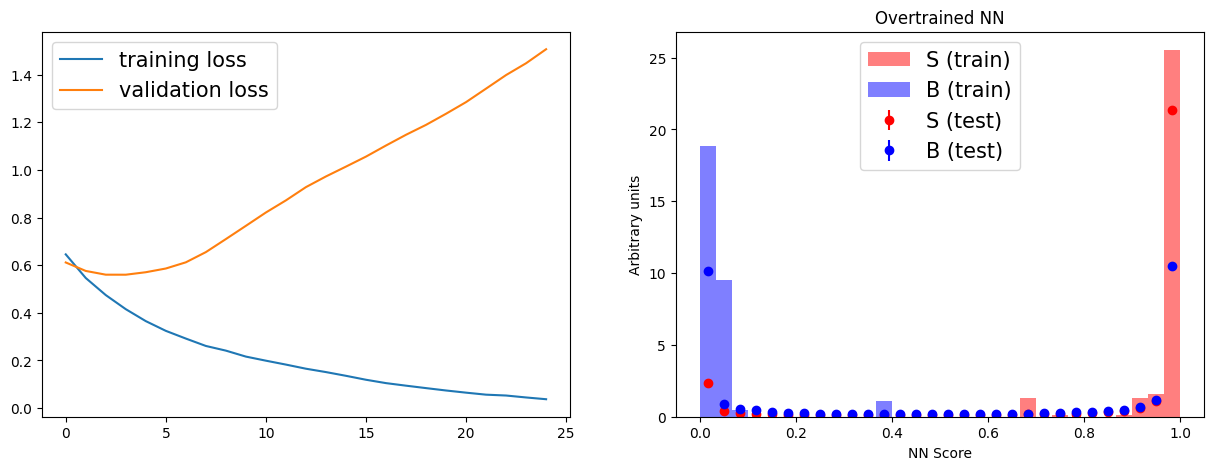

In [51]:
fig, axes = plt.subplots(1, 2, sharex=False, figsize=(15,5))

axes[0].plot(the_overfit.history['loss'],label="training loss")
axes[0].plot(the_overfit.history['val_loss'],label="validation loss")
axes[0].legend(fontsize=15)

axes[1].set_title("Overtrained NN")
compare_train_test(ot_y_pred_train, y_small, ot_y_pred_test, y_test, 
                   xlabel="NN Score", title="Overtrained NN", 
                   weights_train=weights_small.values, weights_test=weights_test.values)
axes[1].legend(loc="upper center",fontsize = 15)

## Exercises

1.   Improve NN AUC and significance by increasing the number of neurons, and layers, epochs, or by any other techniques (google) 
        - (beware of training time)
        - Explore!
        - Loss: [BCE, MSE,]
        - Activations: [relu, leakyrelu, selu, tanh]
2.   Draw NN score for signal and background, training and testing (see overtraining example, or BDT Notebook)
        - feel free to look into *extra_functions.py*
3.   Add Features more features and engineer aditional Features        
___
4.   Draw plot looking at significance for NN ( see BDT notebook), for the same features as BDT
5.   Enable feature permutation importance (see BDT notebook)
6.   Calculate the permutation importance with respect to significance and accuracy. See how Asimov significance changes as features shuffle.






In [52]:
#Some help for BDT comparisons:
y_pred_xgb = np.load("y_pred_xgb.npy")
y_pred_train_xgb = np.load("./y_pred_train_xgb.npy")
weights_train_xgb = np.load("./weights_train_xgb.npy")
y_test_xgb = np.load("./y_test_xgb.npy")
weights_test_xgb = np.load("./weights_test_xgb.npy")

from xgboost import XGBClassifier
import xgboost
xgb = xgboost.XGBClassifier({'nthread': 4})  # init model
xgb.load_model('xgb.model')  # load data

#The model and predictions from the BDT notebook are now in memory!
#plt.bar(data.columns.values, xgb.feature_importances_)

C:\Users\rafae\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\core.py:617: FutureWarning: Pass `objective` as keyword args.
  warnings.warn(msg, FutureWarning)


### Extra: Unweighted Score Plot

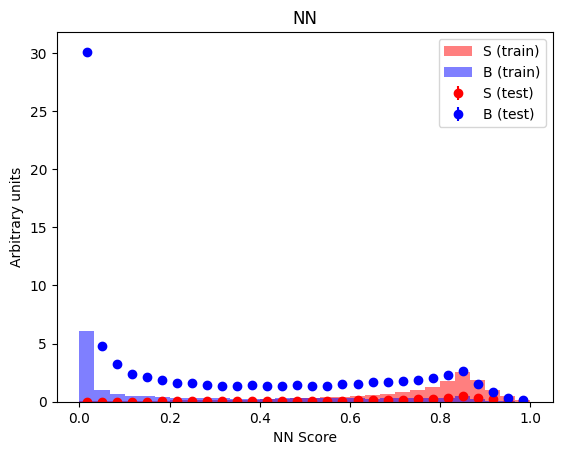

In [53]:
compare_train_test(y_pred_train, y_train, y_pred_test, y_test, 
                   xlabel="NN Score", title="NN", 
                   weights_train=weights_train.values,
                   weights_test=weights_test.values,density=False)